# This project is based on Federated Keras MNIST tutorial.



Copyright @ 2022 Poornachandra Sarang, Ph.D.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.


## Credits: (Developer)
### Jagdish Kharatmol
The project shows you how to use CIFAR dataset in place of MNIST.

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 24 kB/s 
     |████████████████████████████████| 1.3 MB 35.9 MB/s 
     |████████████████████████████████| 463 kB 69.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


In [ ]:
!pip install openfl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 535 kB 26.6 MB/s 
     |████████████████████████████████| 125 kB 72.9 MB/s 
     |████████████████████████████████| 147 kB 65.3 MB/s 
     |████████████████████████████████| 97 kB 7.9 MB/s 
     |████████████████████████████████| 8.8 MB 45.4 MB/s 
     |████████████████████████████████| 161 kB 70.0 MB/s 
     |████████████████████████████████| 200 kB 64.6 MB/s 
     |████████████████████████████████| 2.5 MB 57.7 MB/s 
     |████████████████████████████████| 4.0 MB 12.2 MB/s 
     |████████████████████████████████| 4.0 MB 16.7 MB/s 
     |████████████████████████████████| 51 kB 6.8 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 140 kB 55.4 MB/s 
     |████████████████████████████████| 1.6 MB 46.6 MB/s 
     |████████████████████████████████|

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet

In [ ]:
#Setup default workspace, logging, etc.
fx.init('keras_cnn_mnist')

Creating Workspace Directories
Creating Workspace Templates

New workspace directory structure:
workspace
├── .workspace
├── plan
│   ├── defaults
│   ├── data.yaml
│   ├── cols.yaml
│   └── plan.yaml
├── data
├── src
│   ├── keras_cnn.py
│   ├── tfmnist_inmemory.py
│   ├── mnist_utils.py
│   └── __init__.py
├── save
├── logs
├── requirements.txt
└── cert

6 directories, 10 files
Setting Up Certificate Authority...

1.  Create Root CA
1.1 Create Directories
1.2 Create Database
1.3 Create CA Request and Certificate
2.  Create Signing Certificate
2.1 Create Directories
2.2 Create Database
2.3 Create Signing Certificate CSR
2.4 Sign Signing Certificate CSR
3   Create Certificate Chain

Done.
Creating AGGREGATOR certificate key pair with following settings: CN=261f7fad1e51, SAN=DNS:261f7fad1e51
  Writing AGGREGATOR certificate key pair to: /content/cert/server
The CSR Hash for file server/agg_261f7fad1e51.csr = 5d7589cbb4a6a04c1ab76d4d0db880055ac5adbcc58b1793065d00d8b8530acb1a222a3d7b19d40

# Using CIFAR10
In this code, you will use cifar10 instead of mnist. Note we are now loading cifar dataset in the load_data method.

In [ ]:
#Import and process training, validation, and test images/labels
from keras.datasets import cifar10
import matplotlib.pyplot as plt
# Set the ratio of validation imgs, can't be 0.0
VALID_PERCENT = 0.1

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
split_on = int((1 - VALID_PERCENT) * len(X_train))

train_images = X_train[0:split_on,:,:]
train_labels = to_categorical(y_train)[0:split_on,:]

valid_images = X_train[split_on:,:,:]
valid_labels = to_categorical(y_train)[split_on:,:]

test_images = X_test
test_labels = to_categorical(y_test)

170508288/170498071 [==============================] - 14s 0us/step


# Preprocessing images
As each CIFAR10 image is of 32x32, you will need to apply these dimensions in rgb_to_grayscale function. As the number of classes remain 10, same as MNIST, there is no change in assigning value to classes variable.

In [ ]:
def preprocess(images):  
    img_list=[]
    #converted to grayscale and resized the image
    for index in range(len(images)):
      img_list.append(np.resize(tf.image.rgb_to_grayscale(images[index]),(32,32)))
      
    #Normalize the image array
    image_list = (np.array(img_list) / 255) - 0.5
    return image_list


# Preprocess the images.
train_images = preprocess(train_images)
valid_images = preprocess(valid_images)
test_images = preprocess(test_images)

feature_shape = train_images.shape[1]
classes = 10

In [ ]:
#this is where the data set is prepared for  the model.
fl_data = FederatedDataSet(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)

# Changing model architecture
I have used a different architecture than the one given in MNIST tutorial to improve the model accuracy. You can experiment with your own architectures.

In [ ]:
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPool2D, Activation, MaxPooling2D

def build_model(input_shape,classes):
        model = Sequential()
        model.add(Conv2D(16,  kernel_size = 3,kernel_initializer='he_normal', activation='relu', input_shape = (32, 32, 1)))
        model.add(Conv2D(32,  kernel_size = 3,kernel_initializer='he_normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, kernel_size = 3, kernel_initializer='he_normal', strides=1, activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, kernel_size = 3, strides=1, kernel_initializer='he_normal' ,padding='same', activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(256, kernel_size = 3,kernel_initializer='he_normal', activation='relu'))
        model.add(MaxPooling2D((4, 4)))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(100,kernel_initializer='he_normal', activation = "relu"))
        model.add(Dropout(0.1))
        model.add(Dense(10, kernel_initializer='glorot_uniform', activation = "softmax"))
        # Compile the model
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
        return model

In [ ]:
model=build_model((32,32,1),10)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       73856     
                                                        

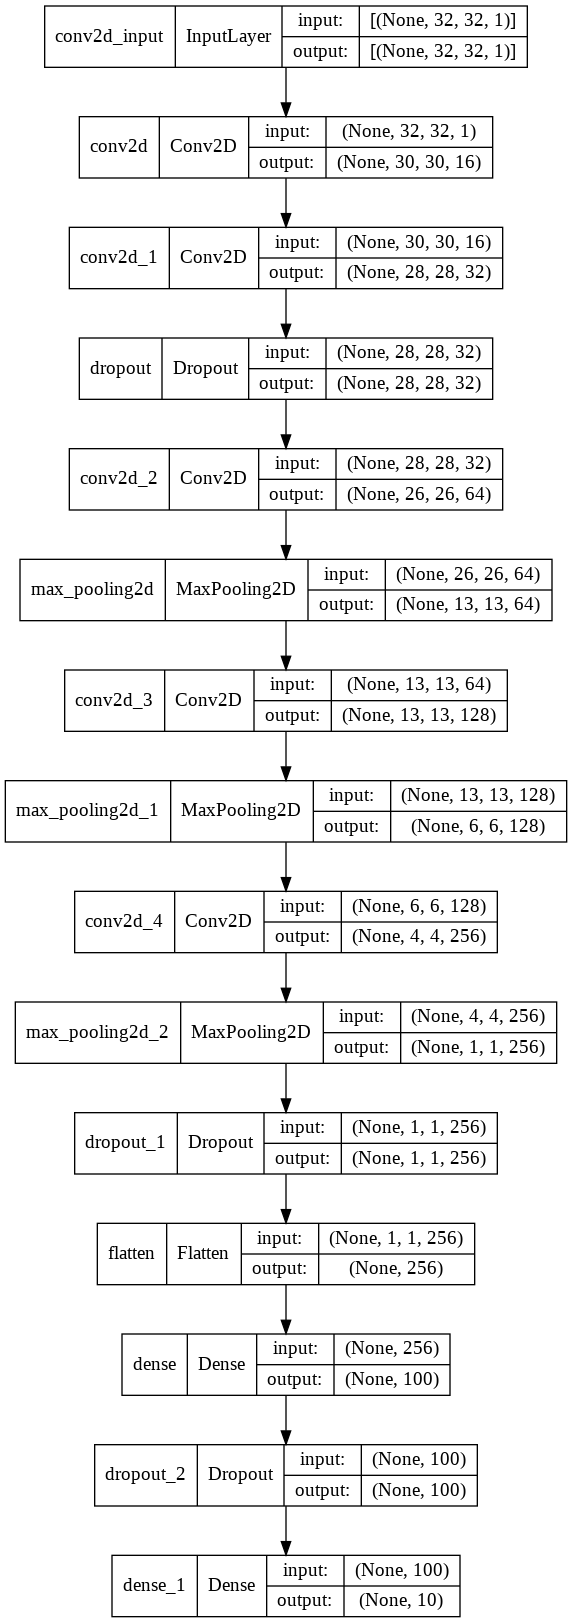

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Create a federated model using the build model function and dataset
fl_model = FederatedModel(build_model,data_loader=fl_data)

# Setting up number of collaborators
We set the number of collaborators to 5 in the setup method. Accordingly, we set the 'collaborators' array. 

In [ ]:
collaborator_models = fl_model.setup(num_collaborators=5)
collaborators = {'one':collaborator_models[0],'two':collaborator_models[1], 'three':collaborator_models[2],'four':collaborator_models[3],'five':collaborator_models[4]}

In [ ]:
print(f'Original training data size: {len(train_images)}')
print(f'Original validation data size: {len(valid_images)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}\n')

#Collaborator four's data
print(f'Collaborator four\'s training data size: {len(collaborator_models[3].data_loader.X_train)}')
print(f'Collaborator tfour\'s validation data size: {len(collaborator_models[3].data_loader.X_valid)}\n')


#Collaborator five's data
print(f'Collaborator five\'s training data size: {len(collaborator_models[4].data_loader.X_train)}')
print(f'Collaborator five\'s validation data size: {len(collaborator_models[4].data_loader.X_valid)}\n')

Original training data size: 45000
Original validation data size: 5000

Collaborator one's training data size: 9000
Collaborator one's validation data size: 1000

Collaborator two's training data size: 9000
Collaborator two's validation data size: 1000

Collaborator three's training data size: 9000
Collaborator three's validation data size: 1000

Collaborator four's training data size: 9000
Collaborator tfour's validation data size: 1000

Collaborator five's training data size: 9000
Collaborator five's validation data size: 1000



# Setting up number of rounds
I have set the number of rounds to 20. You can experiment with this for achieving better accuracies. 

In [ ]:
#Run experiment, return trained FederatedModel
final_fl_model = fx.run_experiment(collaborators,override_config={'aggregator.settings.rounds_to_train':20,"data_loader.settings.collaborator_count": 5})

32/32 [==============================] - 0s 6ms/step - loss: 0.8707 - accuracy: 0.7280


In [ ]:
#Save final model and load into keras
final_fl_model.save_native('final_model')
model = tf.keras.models.load_model('./final_model')

In [ ]:
#Test the final model on our test set
model.evaluate(test_images,test_labels)

313/313 [==============================] - 2s 4ms/step - loss: 0.7357 - accuracy: 0.7489


[0.7356982827186584, 0.7488999962806702]